In [2]:
words = open('Datasets/names.txt', 'r').read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [5]:
min(len(w) for w in words)

2

In [6]:
max(len(w) for w in words)

15

In [7]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [9]:
import torch

In [10]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [11]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [12]:
for w in words[:3]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

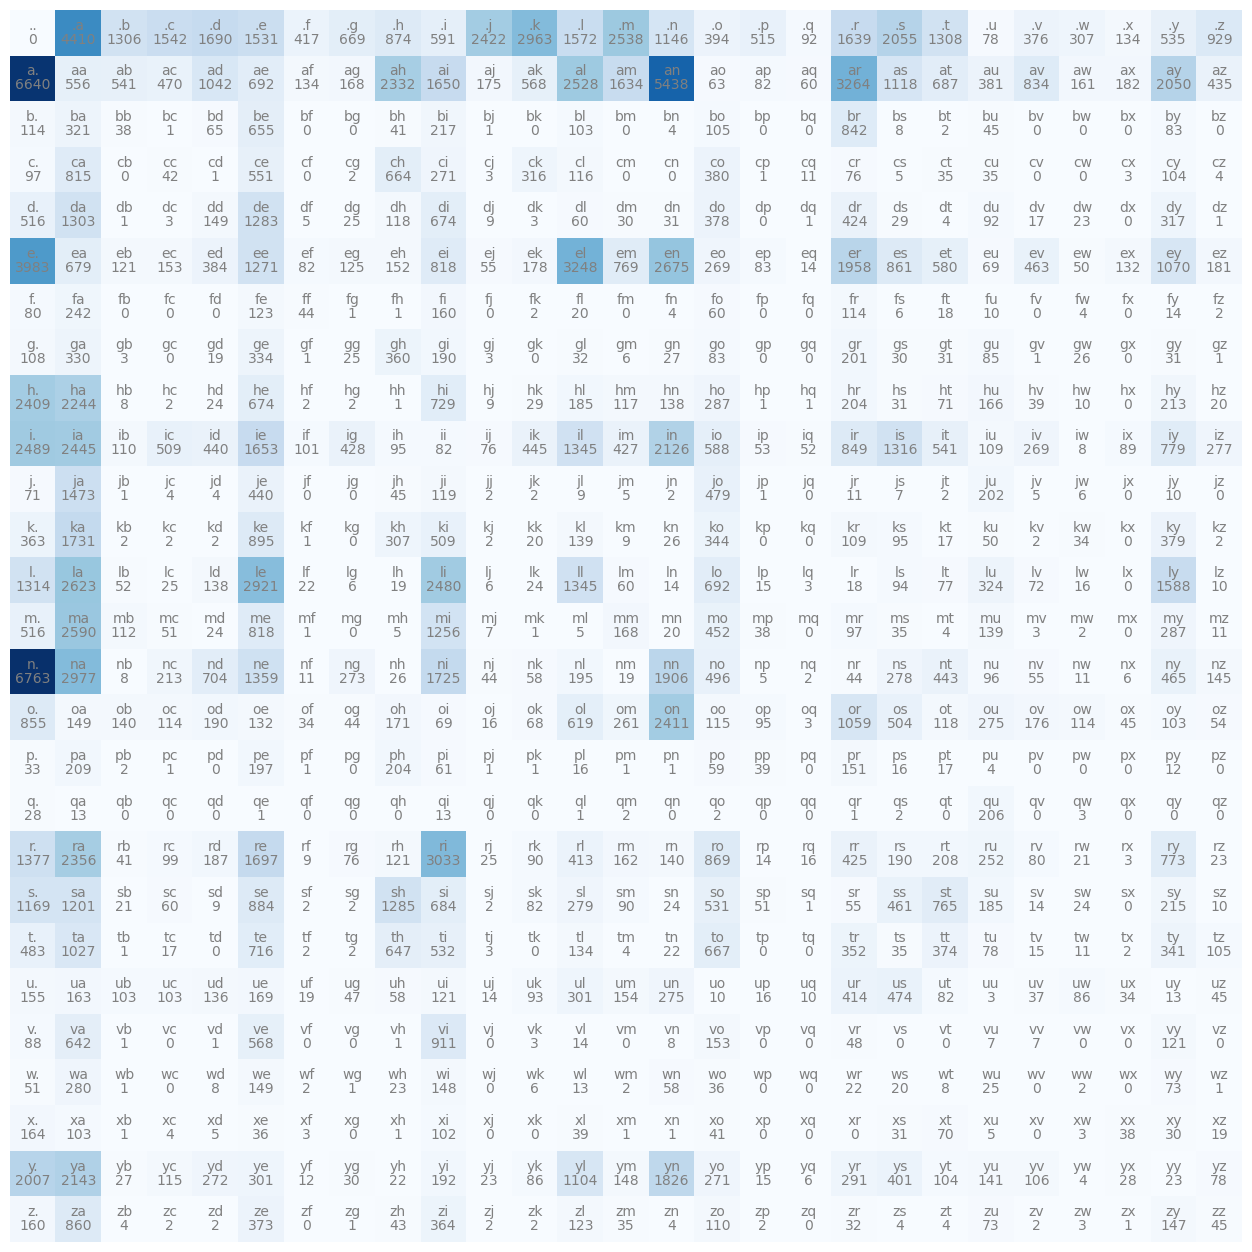

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha = 'center', va = 'bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha = 'center', va = 'top', color='gray')
plt.axis('off')

In [14]:
p = N[0].float()
print(p)
p = p / p.sum()
print(p)

tensor([   0., 4410., 1306., 1542., 1690., 1531.,  417.,  669.,  874.,  591.,
        2422., 2963., 1572., 2538., 1146.,  394.,  515.,   92., 1639., 2055.,
        1308.,   78.,  376.,  307.,  134.,  535.,  929.])
tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])


In [15]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'c'

In [28]:
P = (N+1).float()
P.shape
P /= P.sum(1, keepdim=True)

In [29]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        p= P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


# Goal: maximise likelihood of the data w.r.t model parameters (statistical modelling)
# equivalent to maximising the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihoos
# equivalent to minimising the average negative log likelihoos

# log(a*b*c) = log(a) + log(b) + log(c)

In [38]:
log_likelihood = 0.0
count = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        count+=1
        # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'normalised log likelihood = {nll/count}')

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
normalised log likelihood = 2.4543561935424805


In [63]:
# Create a training set of bigrams (x, y)
xs, ys = [], []
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
        

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [44]:
import torch.nn.functional as F

In [65]:
xenc = F.one_hot(xs, num_classes = 27).float()

In [64]:
W = torch.randn((27, 27))

In [72]:
logits = (xenc @ W) # log-counts
counts = logits.exp() # Count after exponentiated. Equivalent to the N matrix
probs = counts  / counts.sum(1, keepdims=True)
probs

tensor([[0.0280, 0.0521, 0.0060, 0.0309, 0.0043, 0.0696, 0.0324, 0.0386, 0.0461,
         0.0357, 0.0012, 0.0339, 0.1018, 0.0077, 0.0442, 0.0102, 0.0648, 0.0165,
         0.0512, 0.0479, 0.0491, 0.0167, 0.0433, 0.0303, 0.0472, 0.0795, 0.0109],
        [0.0305, 0.0580, 0.0108, 0.0291, 0.0259, 0.0119, 0.0315, 0.0171, 0.0121,
         0.0071, 0.0101, 0.0688, 0.0297, 0.0115, 0.0578, 0.0091, 0.0730, 0.0456,
         0.0217, 0.0974, 0.1210, 0.0534, 0.0352, 0.0418, 0.0068, 0.0325, 0.0508],
        [0.0544, 0.0386, 0.0434, 0.1420, 0.0037, 0.0177, 0.0532, 0.0199, 0.0197,
         0.0600, 0.0441, 0.0258, 0.0116, 0.0079, 0.0089, 0.0045, 0.0125, 0.0203,
         0.0053, 0.2560, 0.0556, 0.0217, 0.0066, 0.0211, 0.0241, 0.0115, 0.0098],
        [0.0544, 0.0386, 0.0434, 0.1420, 0.0037, 0.0177, 0.0532, 0.0199, 0.0197,
         0.0600, 0.0441, 0.0258, 0.0116, 0.0079, 0.0089, 0.0045, 0.0125, 0.0203,
         0.0053, 0.2560, 0.0556, 0.0217, 0.0066, 0.0211, 0.0241, 0.0115, 0.0098],
        [0.1462, 0.0155,

# Summary -=

In [77]:
xs

tensor([ 0,  5, 13, 13,  1])

In [79]:
ys

tensor([ 5, 13, 13,  1,  0])

In [92]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

In [93]:
xenc = F.one_hot(xs, num_classes=27).float() # input to te network: one hot encoding
logits = xenc@W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) #probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

In [94]:
probs.shape

torch.Size([5, 27])

In [95]:
nlls = torch.zeros(5)
for i in range(5):
# i-th bigram:
    x = xs[i].item() # input character index
    y = ys[i].item() # label character index
    print('--------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x}, {y})')
    print('input to the neural net:', x)
    print('output probabilities form the neural net:', probs[i])
    print('output probabilities from the neural ent:', probs[i])
    print('label (actual next character):, y')
    p = probs[i, y]
    print('probability assigned by the net to the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negatice log likelihood:', nll.item())
    nlls[i] = nll

print('========')
print('average negative log likelihood, i.e. loss=', nlls.mean().item())

--------
bigram example 1: .e (indexes 0, 5)
input to the neural net: 0
output probabilities form the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
output probabilities from the neural ent: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character):, y
probability assigned by the net to the correct character: 0.01228625513613224
log likelihood: -4.399273872375488
negatice log likelihood: 4.399273872375488
--------
bigram example 2: em (indexes 5, 13)
input to the neural net: 5
output probabilities form the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0

# ---------- ~~ OPTIMIZATION !! !YAY ____-----

In [101]:
# randomly initializes 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator = g, requires_grad=True)

In [128]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()
# print(loss)

In [129]:
print(loss.item())

3.75925874710083


In [130]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [131]:
# UPdate loop
W.data += -0.01 * W.grad

# ------------- OPTIMISATION !! yay, but this time actually ----------

In [151]:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialise the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [158]:
(W**2).sum()

tensor(2267.8137, grad_fn=<SumBackward0>)

In [160]:
# gradient descent
for k in range(100):

    #forward pass
    xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
    logits = xenc@W # predict logcounts
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) #probabilities for next character
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
    print(loss.item())

    # backward pass
    W.grad = None # set to sero the gradient
    loss.backward()

    #update
    W.data +=-50*W.grad
    

2.483145236968994
2.4831247329711914
2.4831042289733887
2.483083724975586
2.4830634593963623
2.483043670654297
2.4830238819122314
2.483004331588745
2.482984781265259
2.4829657077789307
2.4829466342926025
2.4829273223876953
2.4829087257385254
2.4828903675079346
2.4828717708587646
2.482853412628174
2.482835054397583
2.4828171730041504
2.4827990531921387
2.4827816486358643
2.48276424407959
2.4827466011047363
2.482729434967041
2.482712507247925
2.4826955795288086
2.4826784133911133
2.482661724090576
2.482645273208618
2.4826290607452393
2.4826128482818604
2.4825963973999023
2.4825809001922607
2.482564926147461
2.482548952102661
2.4825334548950195
2.482517957687378
2.4825026988983154
2.482487201690674
2.4824721813201904
2.482457399368286
2.482442617416382
2.4824278354644775
2.4824130535125732
2.4823989868164062
2.48238468170166
2.482370138168335
2.482356309890747
2.48234224319458
2.482328414916992
2.4823145866394043
2.4823007583618164
2.482287645339966
2.482273817062378
2.4822609424591064
2.

In [166]:
# Finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):

    out = []
    ix = 0
    while True:
        # ----
        # BEFORE:
        # p = P[ix]
        # -----
        # NOW:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float() # input to the network: one-hot encoding
        logits = xenc@W # predict logcounts
        counts = logits.exp() # counts, equivalent to N
        probs = counts / counts.sum(1, keepdims=True) #probabilities for next character

        ix = torch.multinomial(p, num_samples = 1, replacement = True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

dexbm.
lhmlsurkil.
zktyhn.
vlnimjtnrinrlknyk.
kh.
